In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, ElasticNet

df_n = pd.read_csv('noisysine.csv')#x,y
data_n = np.array(df_n.values)
df_h = pd.read_csv('hydrodynamics.csv')#x1...5,y
data_h = np.array(df_h.values)

In [261]:
def splitTrVal(data):
    args = np.random.permutation(data.shape[0])
    train_args = np.sort(args[:args.shape[0]*7//8])
    val_args = np.sort(args[args.shape[0]*7//8:])
    return data[train_args], data[val_args]

In [349]:
train_n, val_n = splitTrVal(data_n)
train_h, val_h = splitTrVal(data_h)

In [295]:
###1###
def linReg(data, test):
    X = np.copy(data)
    X[:,-1] = 1
    Y = data[:,-1].reshape(data.shape[0], 1)
    w = (np.random.random(data.shape[1])*0.01).reshape(data.shape[1], 1)
    
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)), X.T),Y)
    X_t = np.copy(test)
    X_t[:,-1] = 1
    Y_t = test[:,-1].reshape(test.shape[0], 1)
    Y_m = np.sum(Y_t)/Y_t.shape[0]
    print("R2 score: ", end="")
    print(1-np.sum((np.dot(X_t,w)-Y_t)**2)/np.sum((Y_m-Y_t)**2))
    return X, Y, w, [X_t, Y_t]

In [305]:
def draw(X, Y, w, ts):
    plt.scatter(X[:,:-1], Y, c='g', label="train")
    plt.scatter(ts[0][:,:-1], ts[1], c='r', label="val")
    x1 = np.min(X[:,:-1])
    x2 = np.max(X[:,:-1])
    y1 = x1*w[0][0] + w[1][0]
    y2 = x2*w[0][0] + w[1][0]
    plt.plot([x1,x2], [y1,y2], color='b')
    plt.legend()
    plt.show()

In [306]:
X, Y, w, ts = linReg(train_n, val_n)

R2 score: 0.0404654214257


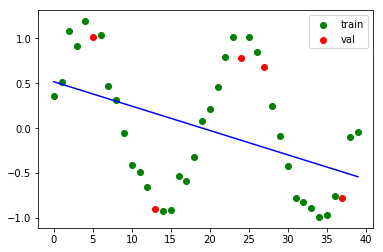

In [307]:
draw(X,Y, w, ts)

In [352]:
t_x, t_y, y_w, ts = linReg(train_h, val_h)

R2 score: 0.64810949118


In [355]:
def polyReg(data, test, deg):
    X_t = np.copy(data)
    X_t[:,-1] = 1
    X = 0
    X_ts = 0
    if data.shape[1]==2:
        X = np.zeros((data.shape[0], deg+1))
        X_ts = np.zeros((test.shape[0], deg+1))
        X[:,0] = 1
        X_ts[:,0] = 1
        for i in range(1,deg+1):
            X[:,i] = X[:,i-1]* data[:,0]
            X_ts[:,i] = X_ts[:,i-1]* test[:,0]
    else:
        X = np.ones((data.shape[0], (data.shape[1]-1)*(data.shape[1]+2)//2+1))
        X_ts = np.ones((test.shape[0], (data.shape[1]-1)*(data.shape[1]+2)//2+1))
        X[:,1:data.shape[1]] = data[:,0:data.shape[1]-1]
        X_ts[:,1:test.shape[1]] = test[:,0:test.shape[1]-1]
        k = data.shape[1]
        for i in range(1,data.shape[1]):
            for j in range(i,data.shape[1]):
                X[:,k] = data[:,i]*data[:,j]
                X_ts[:,k] = test[:,i]*test[:,j]
                k += 1
    Y = data[:,-1].reshape(data.shape[0], 1)
    w = (np.random.random((X.shape[1],1))*0.01)
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)), X.T),Y)
    Y_ts = test[:,-1].reshape(test.shape[0], 1)
    Y_m = np.sum(Y_ts)/Y_ts.shape[0]
    print("R2 score: ", end="")
    print(1-np.sum((np.dot(X_ts,w)-Y_ts)**2)/np.sum((Y_m-Y_ts)**2))
    return X, Y, w, [X_ts, Y_ts]

In [356]:
def draw2(X, Y, w, ts):
    plt.scatter(X[:,1], Y, c='g', label="train")
    plt.scatter(ts[0][:,1], ts[1], c='r', label="val")
    x1_a = np.argmin(X[:,1])
    x2_a = np.argmax(X[:,1])
    x1 = X[x1_a,1]
    x2 = X[x2_a,1]
    X_t2 = np.arange(x1,x2,0.1)
    #X_t2 = X_t2.reshape(X_t2.shape[0],1)
    X_t = np.ones((X_t2.shape[0], w.shape[0]))
    for i in range(1,w.shape[0]):
        X_t[:,i] = X_t[:,i-1]*X_t2
    Y_t = np.dot(X_t, w)
    plt.plot(X_t[:,1], Y_t, color='b')
    plt.xlim(xmax=x2, xmin=x1)
    plt.legend()
    plt.show()

R2 score: 0.46891703451


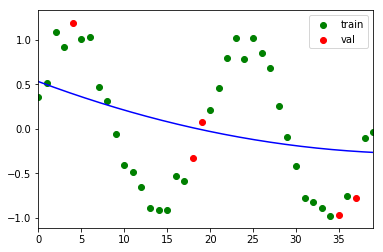

In [357]:
X1, Y1, w1, ts = polyReg(train_n, val_n, 2)
draw2(X1, Y1, w1, ts)

R2 score: 0.567767851099


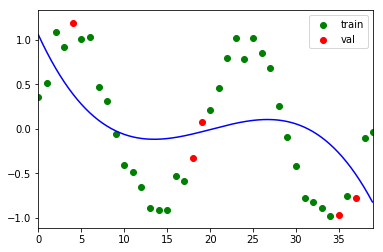

In [358]:
X1, Y1, w1, ts = polyReg(train_n, val_n, 3)
draw2(X1, Y1, w1, ts)

R2 score: 0.523218170661


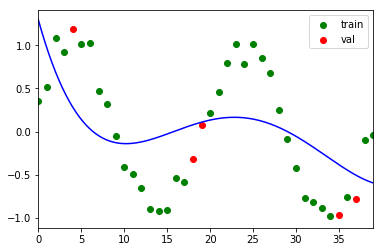

In [359]:
X1, Y1, w1, ts = polyReg(train_n, val_n, 4)
draw2(X1, Y1, w1, ts)

R2 score: 0.942117850529


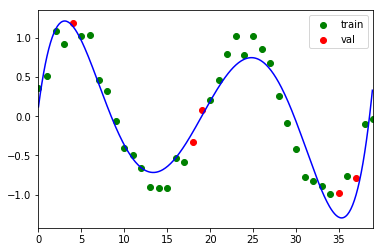

In [360]:
X1, Y1, w1, ts = polyReg(train_n, val_n, 5)
draw2(X1, Y1, w1, ts)

In [374]:
_ = linReg(train_h, val_h)

R2 score: 0.64810949118


In [375]:
_ = polyReg(train_h, val_h, 2)

R2 score: 0.999967333056


In [362]:
###2###
def linRedge(data, test, alpha):
    X = np.copy(data)
    X[:,-1] = 1
    Y = data[:,-1].reshape(data.shape[0], 1)
    w = (np.random.random(data.shape[1])*0.01).reshape(data.shape[1], 1)
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)+alpha*np.eye(X.shape[1], dtype=int)), X.T),Y)
    X_t = np.copy(test)
    X_t[:,-1] = 1
    Y_t = test[:,-1].reshape(test.shape[0], 1)
    Y_m = np.sum(Y_t)/Y_t.shape[0]
    R2 = 1-np.sum((np.dot(X_t,w)-Y_t)**2)/np.sum((Y_m-Y_t)**2)
    return X, Y, w, [X_t, Y_t], R2

In [363]:
X, Y, w_max, ts, R2_max = 0, 0, 0, 0, 0
alph = 0
for i in np.arange(-10, 5, 0.1):
    alp = 10**i
    X, Y, w, ts, R2 = linRedge(train_n, val_n, alp)
    if R2 > R2_max:
        w_max, R2_max = w, R2
        alph = alp
w, R2 = w_max, R2_max
print("R2 score: " + str(R2) + ", alpha: " + str(alph))

R2 score: 0.485165527808, alpha: 1e-10


In [376]:
def polyRedge(data, test, deg, alpha):
    X_t = np.copy(data)
    X_t[:,-1] = 1
    X = 0
    X_ts = 0
    if data.shape[1]==2:
        X = np.zeros((data.shape[0], deg+1))
        X_ts = np.zeros((test.shape[0], deg+1))
        X[:,0] = 1
        X_ts[:,0] = 1
        for i in range(1,deg+1):
            X[:,i] = X[:,i-1]* data[:,0]
            X_ts[:,i] = X_ts[:,i-1]* test[:,0]
    else:
        X = np.ones((data.shape[0], (data.shape[1]-1)*(data.shape[1]+2)//2+1))
        X_ts = np.ones((test.shape[0], (data.shape[1]-1)*(data.shape[1]+2)//2+1))
        X[:,1:data.shape[1]] = data[:,0:data.shape[1]-1]
        X_ts[:,1:test.shape[1]] = test[:,0:test.shape[1]-1]
        k = data.shape[1]
        for i in range(1,data.shape[1]):
            for j in range(i,data.shape[1]):
                X[:,k] = data[:,i]*data[:,j]
                X_ts[:,k] = test[:,i]*test[:,j]
                k += 1
    Y = data[:,-1].reshape(data.shape[0], 1)
    w = (np.random.random((X.shape[1],1))*0.01)
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)+alpha*np.eye(X.shape[1], dtype=int)), X.T),Y)
    Y_ts = test[:,-1].reshape(test.shape[0], 1)
    Y_m = np.sum(Y_ts)/Y_ts.shape[0]
    R2 = 1-np.sum((np.dot(X_ts,w)-Y_ts)**2)/np.sum((Y_m-Y_ts)**2)
    return X, Y, w, R2, [X_ts, Y_ts]

In [377]:
def max_alph(train, val, deg):
    X_max, Y_max, w_max, R2_max, ts_m = 0, 0, 0, 0, 0
    alph = 0
    for i in np.arange(-10, 5, 0.1):
        alp = 10**i
        X, Y, w, R2, ts = polyRedge(train, val, deg, alp)
        if R2 > R2_max:
            X_max, Y_max, w_max, R2_max, ts_m = X, Y, w, R2, ts
            alph = alp
    X, Y, w, R2, ts = X_max, Y_max, w_max, R2_max, ts_m
    print("R2 score: " + str(R2) + ", alpha: " + str(alph))
    draw2(X, Y, w, ts)

R2 score: 0.468917034507, alpha: 1e-10


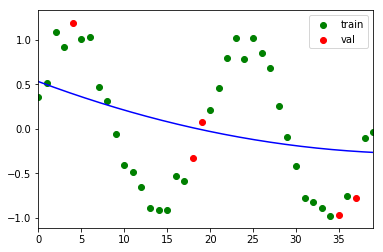

In [378]:
max_alph(train_n, val_n, 2)

R2 score: 0.567767851091, alpha: 1e-10


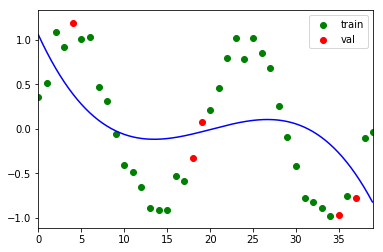

In [379]:
max_alph(train_n, val_n, 3)

R2 score: 0.523218170653, alpha: 1e-10


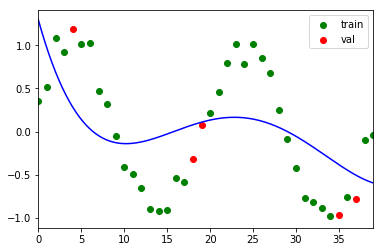

In [380]:
max_alph(train_n, val_n, 4)

R2 score: 0.946532460382, alpha: 1.0


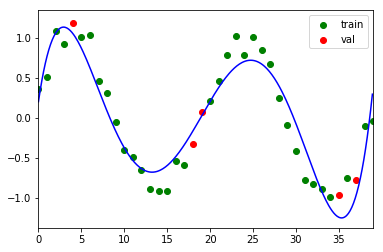

In [381]:
max_alph(train_n, val_n, 5)

In [382]:
X, Y, w_max, ts, R2_max = 0, 0, 0, 0, 0
alph = 0
for i in np.arange(-10, 5, 0.1):
    alp = 10**i
    X, Y, w, ts, R2 = linRedge(train_h, val_h, alp)
    if R2 > R2_max:
        w_max, R2_max = w, R2
        alph = alp
w, R2 = w_max, R2_max
print("R2 score: " + str(R2) + ", alpha: " + str(alph))

R2 score: 0.648109491171, alpha: 1e-10


In [383]:
X_max, Y_max, w_max, R2_max, ts_m = 0, 0, 0, 0, 0
alph = 0
for i in np.arange(-10, 5, 0.1):
    alp = 10**i
    X, Y, w, R2, ts = polyRedge(train_h, val_h, 2, alp)
    if R2 > R2_max:
        X_max, Y_max, w_max, R2_max, ts_m = X, Y, w, R2, ts
        alph = alp
X, Y, w, R2, ts = X_max, Y_max, w_max, R2_max, ts_m
print("R2 score: " + str(R2) + ", alpha: " + str(alph))

R2 score: 0.999967341957, alpha: 6.3095734448e-09


In [536]:
###3###
def Lss(train, val, draw=True):
    R2_max = 0
    alp_max = 0
    for i in np.arange(-10, 5, 0.1):
        alp = 10**i
        clf = Lasso(alpha=alp)
        clf.fit(train[:,:-1], train[:,-1])
        y_pr = clf.predict(val[:,:-1])
        Y_m = np.sum(val[:,-1])/val.shape[0]
        R2 = 1-np.sum((y_pr-val[:,-1])**2)/np.sum((Y_m-val[:,-1])**2)
        if (R2 > R2_max):
            R2_max = R2
            alp_max = alp
    clf = Lasso(alpha=alp_max)
    clf.fit(train[:,:-1], train[:,-1])
    print("num features: " + str(np.sum(np.where(clf.coef_[1:] != 0))))
    print("R2: " + str(R2_max))
    if draw:
        draw3(train,train[:,-1].reshape(train.shape[0],1), clf.coef_, [val, val[:,-1].reshape(val.shape[0],1)])
    return R2_max, clf

In [537]:
def draw3(X, Y, w, ts):
    plt.scatter(X[:,:-1], Y, c='g', label="train")
    plt.scatter(ts[0][:,:-1], ts[1], c='r', label="val")
    x1 = np.min(X[:,:-1])
    x2 = np.max(X[:,:-1])
    y1 = x1*w[0]
    y2 = x2*w[0]
    plt.plot([x1,x2], [y1,y2], color='b')
    plt.legend()
    plt.show()

num features: 0
R2: 0.485165527795


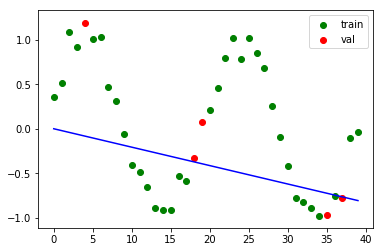

In [538]:
R2, clf = Lss(train_n, val_n)

In [568]:
def polyLss(data, test, deg, alpha, draw=False, elastic=False, l1=0.5):
    X_t = np.copy(data)
    X_t[:,-1] = 1
    X = 0
    X_ts = 0
    if data.shape[1]==2:
        X = np.zeros((data.shape[0], deg+1))
        X_ts = np.zeros((test.shape[0], deg+1))
        X[:,0] = 1
        X_ts[:,0] = 1
        for i in range(1,deg+1):
            X[:,i] = X[:,i-1]* data[:,0]
            X_ts[:,i] = X_ts[:,i-1]* test[:,0]
    else:
        X = np.ones((data.shape[0], (data.shape[1]-1)*(data.shape[1]+2)//2+1))
        X_ts = np.ones((test.shape[0], (data.shape[1]-1)*(data.shape[1]+2)//2+1))
        X[:,1:data.shape[1]] = data[:,0:data.shape[1]-1]
        X_ts[:,1:test.shape[1]] = test[:,0:test.shape[1]-1]
        k = data.shape[1]
        for i in range(1,data.shape[1]):
            for j in range(i,data.shape[1]):
                X[:,k] = data[:,i]*data[:,j]
                X_ts[:,k] = test[:,i]*test[:,j]
                k += 1
    Y = data[:,-1].reshape(data.shape[0], 1)
    clf = None
    if not elastic:
        clf = Lasso(alpha=alpha, max_iter=10000)
    else:
        clf = ElasticNet(alpha=alpha, l1_ratio=l1)
    clf.fit(X, Y)
    y_pr = clf.predict(X_ts)
    Y_ts = test[:,-1].reshape(test.shape[0], 1)
    Y_m = np.sum(Y_ts)/Y_ts.shape[0]
    R2 = 1-np.sum((y_pr-Y_ts)**2)/np.sum((Y_m-Y_ts)**2)
    return X, Y, clf.coef_, R2, [X_ts, Y_ts]

In [569]:
def LssF(deg, train_n=train_n, val_n=val_n, draw=True):
    X_max, Y_max, w_max, R2_max, ts_m = 0, 0, 0, -100000, 0
    alph = 0
    for i in np.arange(-10, 5, 1.0):
        alp = 10**i
        X, Y, w, R2, ts = polyLss(train_n, val_n, deg, alph)
        if R2 > R2_max:
            X_max, Y_max, w_max, R2_max, ts_m = X, Y, w, R2, ts
            alph = alp
    X, Y, w, R2, ts = X_max, Y_max, w_max, R2_max, ts_m
    print("num features: " + str(np.sum(np.where(w[1:] != 0))))
    print("R2 score: " + str(R2) + ", alpha: " + str(alph))
    if draw:
        draw2(X, Y, w, ts)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


num features: 1
R2 score: -4.63179709749, alpha: 1.0


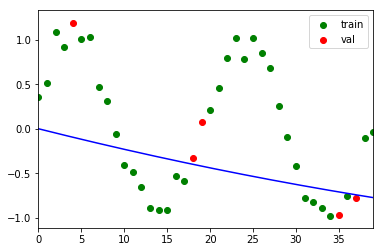

In [570]:
LssF(2)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


num features: 3
R2 score: -4.71670811057, alpha: 10.0


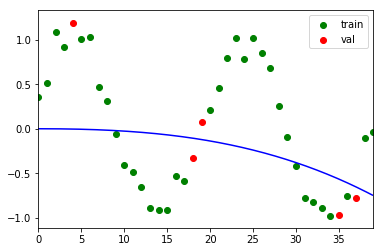

In [545]:
LssF(3)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


num features: 6
R2 score: -4.69933301841, alpha: 10.0


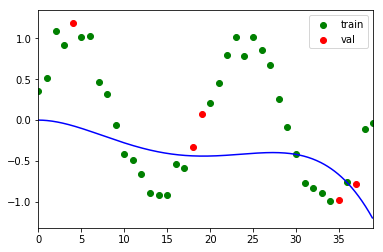

In [546]:
LssF(4)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


num features: 7
R2 score: -4.75052688656, alpha: 10000.0


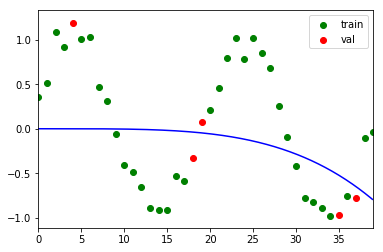

In [547]:
LssF(5)

In [602]:
def LssFEL(deg, train_n=train_n, val_n=val_n, draw=True):
    X_max, Y_max, w_max, R2_max, ts_m = 0, 0, 0, -100000, 0
    alph = 0
    l1_m = 0
    for i in np.arange(-10, 5, 1.0):
        for l1 in np.arange(0.0,1.0,0.1):
            alp = 10**i
            X, Y, w, R2, ts = polyLss(train_n, val_n, deg, alph, elastic=True, l1=l1)
            if R2 > R2_max:
                X_max, Y_max, w_max, R2_max, ts_m = X, Y, w, R2, ts
                alph = alp
                l1_m = l1
    X, Y, w, R2, ts = X_max, Y_max, w_max, R2_max, ts_m
    print("num features: " + str(np.sum(np.where(w[1:] != 0))))
    print("R2 score: " + str(R2) + ", alpha: " + str(alph) + ", l1: " + str(l1_m))
    if draw:
        draw2(X, Y, w, ts)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


num features: 1
R2 score: -4.63713667952, alpha: 1e-10, l1: 0.9


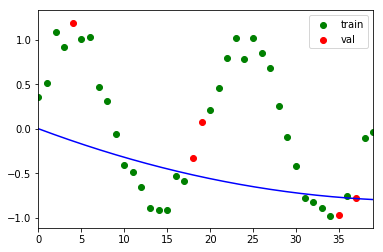

In [603]:
LssFEL(2)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


num features: 3
R2 score: -4.79217714784, alpha: 1e-10, l1: 0.9


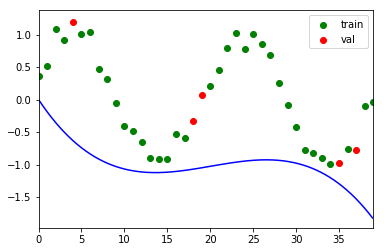

In [604]:
LssFEL(3)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


num features: 6
R2 score: -4.78534925325, alpha: 1e-10, l1: 0.9


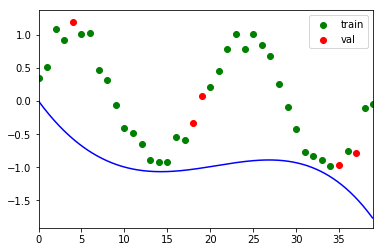

In [605]:
LssFEL(4)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


num features: 10
R2 score: -4.79806937068, alpha: 1e-10, l1: 0.9


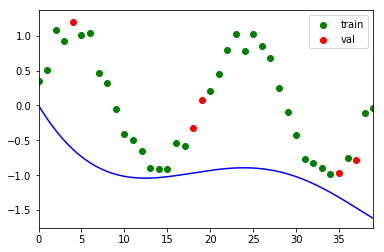

In [606]:
LssFEL(5)